> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset: Factors of No-Show to Dr. Appointments


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. In order to work with the data in this workspace, you also need to upload it to the workspace. To do so, click on the jupyter icon in the upper left to be taken back to the workspace directory. There should be an 'Upload' button in the upper right that will let you add your data file(s) to the workspace. You can then click on the .ipynb file name to come back here.

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline 
matplotlib.style.use('ggplot')
import seaborn as sb
from patsy import dmatrices

from sklearn.preprocessing import MinMaxScaler as min_max_scaler
from sklearn.linear_model import LogisticRegression as logReg
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.svm import SVC as svc
from sklearn.metrics import confusion_matrix as c_m, precision_score as p_s, recall_score as r_s, roc_auc_score as roc, f1_score as f1
from sklearn.model_selection import train_test_split as tts, StratifiedKFold as skf 
from sklearn.utils import resample

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('no_shows.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
#Getting descriptive statistics of the primary data such as min, max, mean, median, etc.
print(df.describe())

print('\n\n')
#lets see if there are any null values and the data types 
df.info()

print('\n\n')
#let's see if any of there are any duplicates. 
print('Total number of duplicates:', df.duplicated().sum())

          PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205       0.297675   
min    3.921784e+04   5.030230e+06      -1.000000       0.000000   
25%    4.172614e+12   5.640286e+06      18.000000       0.000000   
50%    3.173184e+13   5.680573e+06      37.000000       0.000000   
75%    9.439172e+13   5.725524e+06      55.000000       0.000000   
max    9.999816e+14   5.790484e+06     115.000000       1.000000   

        Hipertension       Diabetes     Alcoholism        Handcap  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.197246       0.071865       0.030400       0.022248   
std         0.397921       0.258265       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       

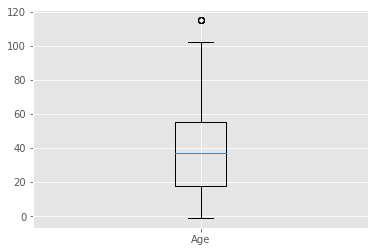

 115    5
 100    4
 102    2
 99     1
-1      1
Name: Age, dtype: int64

In [4]:
#This makes detecting the outliers visually easy (except for -1)
plt.boxplot(df['Age'], labels=['Age'])
plt.show()

#this helps to count the ages that need removed (-1 and 115)
df['Age'].value_counts().tail()

In [5]:
print('\n Handicap value counts:')
df['Handcap'].value_counts()


 Handicap value counts:


0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [6]:
#Making sure these are all zeros and ones 
df.SMS_received.unique(), df.Hipertension.unique(), df.Alcoholism.unique(), \
df.Diabetes.unique(), df.Scholarship.unique()

(array([0, 1]), array([1, 0]), array([0, 1]), array([0, 1]), array([0, 1]))

As we can see there are fortunately no null values, but this data still needs cleaned. The age value of-1 needs removed. The 5 people aged at 115 also needs removed (unlikely five people are living at that age). The 'Handcap' value range of 0-4 is not the same 0-1 range of the other features, so that will be preprocessed later. I will not remove the 3 people with 4 handicaps because I know much less about the max number of disbabilities a person can have than the max age people can live. 

> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning

In [7]:
#getting rid of the -1 in Age
df.drop(df[df.Age < 0].index, inplace=True)
#removes the supposed 115 year olds
df.drop(df[df.Age > 110].index, inplace=True)

In [8]:
#let's check to see if these rows are gone
print('New data shape:', df.shape)
print('New min age:', df.Age.min())
print('New max age:', df.Age.max())

New data shape: (110521, 14)
New min age: 0
New max age: 102


##### Let's add a column for the number of days between the scheduled day and appointment day. 

In [9]:
#difference between the these features after converting them to datetime using pd.to_datetime()
df['WaitDays'] = pd.to_datetime(df.AppointmentDay) - pd.to_datetime(df.ScheduledDay)

#Here we will find any recording errors where the scheduled date occurred after the appointment day)
df['WaitDays'] = df['WaitDays'].apply(lambda x: int(x.days))

In [10]:
df.query('WaitDays <  0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No,-1
19,7.223289e+12,5640433,F,2016-04-29T10:43:14Z,2016-04-29T00:00:00Z,46,DA PENHA,0,0,0,0,0,0,No,-1
24,8.734858e+12,5641780,F,2016-04-29T14:19:19Z,2016-04-29T00:00:00Z,65,TABUAZEIRO,0,0,0,0,0,0,No,-1
26,2.578785e+10,5641781,F,2016-04-29T14:19:42Z,2016-04-29T00:00:00Z,45,BENTO FERREIRA,0,1,0,0,0,0,No,-1
28,5.926172e+12,5642400,M,2016-04-29T15:48:02Z,2016-04-29T00:00:00Z,51,SÃO PEDRO,0,0,0,0,0,0,No,-1


In [11]:
#Checking to see how many of the appointment times are set after the time of scheduling. 
df.query('WaitDays < 0 ')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No,-1
19,7.223289e+12,5640433,F,2016-04-29T10:43:14Z,2016-04-29T00:00:00Z,46,DA PENHA,0,0,0,0,0,0,No,-1
24,8.734858e+12,5641780,F,2016-04-29T14:19:19Z,2016-04-29T00:00:00Z,65,TABUAZEIRO,0,0,0,0,0,0,No,-1
26,2.578785e+10,5641781,F,2016-04-29T14:19:42Z,2016-04-29T00:00:00Z,45,BENTO FERREIRA,0,1,0,0,0,0,No,-1
28,5.926172e+12,5642400,M,2016-04-29T15:48:02Z,2016-04-29T00:00:00Z,51,SÃO PEDRO,0,0,0,0,0,0,No,-1


It shows that over 30,000 appointments are after the time of their scheduling, but that is not entirely true. It is actually the case that the appointments were done on the same day for most of these. It shows -1 for wait days because the exact time of day was not recorded for the atual appointment, and only for the scheduling time. So we can assume the scheduled day and appointment day are the same. However, are there any appointment times less than -1 (which would indicate error)?

In [12]:
df.query('WaitDays < -1')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays
27033,7.839273e+12,5679978,M,2016-05-10T10:51:53Z,2016-05-09T00:00:00Z,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,-2
55226,7.896294e+12,5715660,F,2016-05-18T14:50:41Z,2016-05-17T00:00:00Z,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,-2
64175,2.425226e+13,5664962,F,2016-05-05T13:43:58Z,2016-05-04T00:00:00Z,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,-2
71533,9.982316e+14,5686628,F,2016-05-11T13:49:20Z,2016-05-05T00:00:00Z,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,-7
72362,3.787482e+12,5655637,M,2016-05-04T06:50:57Z,2016-05-03T00:00:00Z,7,TABUAZEIRO,0,0,0,0,0,0,Yes,-2


Here we have only five. So I will just delete these, as these five entries distort the contribution of the WaitDays variable to the no-show outcome. 

In [13]:
df.drop(df.loc[df.WaitDays < -1].index, inplace = True)

#We will also convert the leftover -1 values to 0 because they scheduling day and appointment day were the same
df.WaitDays = df.WaitDays.apply(lambda x: 0 if x == -1 else x)
df.WaitDays.describe()

count    110516.000000
mean          9.533190
std          15.028018
min           0.000000
25%           0.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: WaitDays, dtype: float64

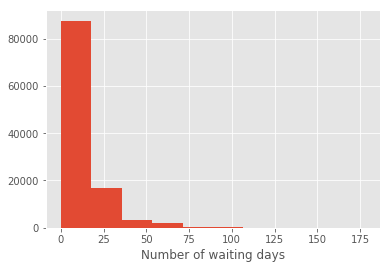

In [14]:
plt.hist(df.WaitDays)
plt.xlabel('Number of waiting days');

This has an expected strong positive-skew given hospital administrators and patients would generally want to minimize the time between scheduled and appointment dates. 

Now I'll drop the date columns and the id numbers. 

In [15]:
dates = df.loc[:, ['ScheduledDay', 'AppointmentDay']] #saves a copy of dates in variable
df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], axis=1, inplace=True)
 

In [16]:
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0


In [17]:
#fixes the simple misspellings 
df = df.rename(columns={'No-show':'No_show', 'Handcap':'Handicap', 'Hipertension':'Hypertension', 'Neighbourhood': 'Neighborhood'})
df.head()

,Gender,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,WaitDays
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0


### Data Preprocessing

First, we will 1,0 encode these two columns: 'No-show' and 'Gender'. I used .apply() to ensure that every 'Yes' in the 'No-show' us a 1, and every 'No' is zero. So for every 1 there is a no-show, and for every 0 the patient showed up.

In [18]:
df2 = df.copy #this keeps the cleaned, though unprocessed original data in storage so we may access it for plotting

In [19]:
#this separates all 81 neighborhoods into 81 separate columns full of zeros with only one 1 marking and adds 
df = pd.concat([df, pd.get_dummies(df['Neighborhood'])], axis=1)
df.columns

Index(['Gender', 'Age', 'Neighborhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'No_show',
       'WaitDays', 'AEROPORTO', 'ANDORINHAS', 'ANTÔNIO HONÓRIO',
       'ARIOVALDO FAVALESSA', 'BARRO VERMELHO', 'BELA VISTA', 'BENTO FERREIRA',
       'BOA VISTA', 'BONFIM', 'CARATOÍRA', 'CENTRO', 'COMDUSA', 'CONQUISTA',
       'CONSOLAÇÃO', 'CRUZAMENTO', 'DA PENHA', 'DE LOURDES', 'DO CABRAL',
       'DO MOSCOSO', 'DO QUADRO', 'ENSEADA DO SUÁ', 'ESTRELINHA',
       'FONTE GRANDE', 'FORTE SÃO JOÃO', 'FRADINHOS', 'GOIABEIRAS',
       'GRANDE VITÓRIA', 'GURIGICA', 'HORTO', 'ILHA DAS CAIEIRAS',
       'ILHA DE SANTA MARIA', 'ILHA DO BOI', 'ILHA DO FRADE',
       'ILHA DO PRÍNCIPE', 'ILHAS OCEÂNICAS DE TRINDADE', 'INHANGUETÁ',
       'ITARARÉ', 'JABOUR', 'JARDIM CAMBURI', 'JARDIM DA PENHA',
       'JESUS DE NAZARETH', 'JOANA D´ARC', 'JUCUTUQUARA', 'MARIA ORTIZ',
       'MARUÍPE', 'MATA DA PRAIA', 'MONTE BELO', 'MORADA DE CAMBURI',
       'MÁRIO CYPR

In [20]:
print(df.shape)
df.head(10)

(110516, 92)


,Gender,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,...,SANTOS REIS,SEGURANÇA DO LAR,SOLON BORGES,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,UNIVERSITÁRIO,VILA RUBIM
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0
5,F,76,REPÚBLICA,0,1,0,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0
6,F,23,GOIABEIRAS,0,0,0,0,0,0,Yes,...,0,0,0,0,0,0,0,0,0,0
7,F,39,GOIABEIRAS,0,0,0,0,0,0,Yes,...,0,0,0,0,0,0,0,0,0,0
8,F,21,ANDORINHAS,0,0,0,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0
9,F,19,CONQUISTA,0,0,0,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0


Here I one-hot encode the No-show and Gender variable to 1s and 0s. 

In [21]:
df['Noshow_onehot'] = df['No_show'].apply(lambda x: 1 if x == 'Yes' else 0) #one-hot encodes 'Yes' to 1s and 'No' to 0s.
df['Gender_onehot'] = df['Gender'].apply(lambda x: 1 if x =='F' else 0) #encodes females to 1s and males to 0s 
print(df.Noshow_onehot.value_counts())

0    88205
1    22311
Name: Noshow_onehot, dtype: int64


In [22]:
df = pd.concat([df, pd.get_dummies(df['Handicap'], prefix='Handicap')], axis=1)
df.head()

,Gender,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,...,TABUAZEIRO,UNIVERSITÁRIO,VILA RUBIM,Noshow_onehot,Gender_onehot,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,...,0,0,0,0,1,1,0,0,0,0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,...,0,0,0,0,0,1,0,0,0,0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,...,0,0,0,0,1,1,0,0,0,0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,...,0,0,0,0,1,1,0,0,0,0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,...,0,0,0,0,1,1,0,0,0,0


So far, we have only 'Age', and 'WaitDays' as continuous variables, not either 0 or 1, significantly scaled outside this range. They need preprocessed for more accurate analysis, so the algorithms do not mistake the higher numbers of these variable to mean stronger connection to the no-show variable. Before preprocessing them, it would be helpful to know the shape each each data distribution. 

For plotting distributions side by side for comparisons: http://benalexkeen.com/feature-scaling-with-scikit-learn/

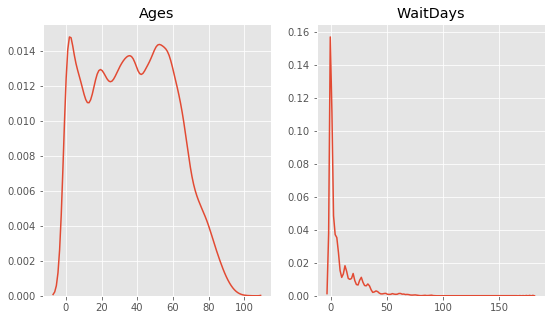

In [23]:
fig, (plot1, plot2) = plt.subplots(ncols=2, figsize=(9, 5))
plot1.set_title('Ages')
sb.kdeplot(df['Age'],legend=False, ax=plot1)
plot2.set_title('WaitDays')
sb.kdeplot(df['WaitDays'],legend=False, ax=plot2)
plt.show();

As we can see, the data is well outside the [0,1] range, but we can rescale the data to the no-show scale while retaining the distribution, as below. 

In [24]:
shape = (df.shape[0], 1)
mms = min_max_scaler()
#Creates new columns with mmn meaning 'min-max normalized
df["Age_mmn"] = mms.fit_transform(np.array(df.Age).reshape(shape))
df["WaitDays_mmn"] = mms.fit_transform(np.array(df.WaitDays).reshape(shape))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


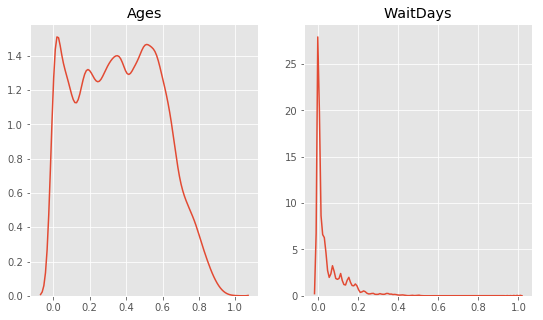

In [25]:
#Plotting the three rescaled variables that should be within the range [0,1] and have the same data
#distribution
fig, (plot1, plot2) = plt.subplots(ncols=2, figsize=(9, 5))
plot1.set_title('Ages')
sb.kdeplot(df['Age_mmn'],legend=False, ax=plot1)
plot2.set_title('WaitDays')
sb.kdeplot(df['WaitDays_mmn'],legend=False, ax=plot2)
plt.show();

In [26]:
df.head()

,Gender,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,...,VILA RUBIM,Noshow_onehot,Gender_onehot,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4,Age_mmn,WaitDays_mmn
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,...,0,0,1,1,0,0,0,0,0.607843,0.0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,...,0,0,0,1,0,0,0,0,0.549020,0.0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,...,0,0,1,1,0,0,0,0,0.607843,0.0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,...,0,0,1,1,0,0,0,0,0.078431,0.0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,...,0,0,1,1,0,0,0,0,0.549020,0.0


In [27]:
print(df['Age_mmn'].describe(), '\n\n', df['WaitDays_mmn'].describe())

count    110516.000000
mean          0.363587
std           0.226514
min           0.000000
25%           0.176471
50%           0.362745
75%           0.539216
max           1.000000
Name: Age_mmn, dtype: float64 

 count    110516.000000
mean          0.053557
std           0.084427
min           0.000000
25%           0.000000
50%           0.016854
75%           0.078652
max           1.000000
Name: WaitDays_mmn, dtype: float64


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

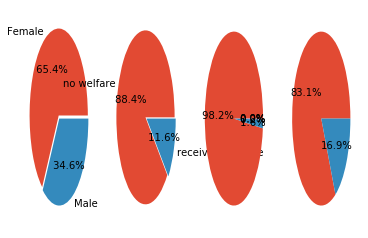

In [80]:
def v_counts(column):
    value_counts = df.query('No_show =="Yes"')[column].value_counts()
    return value_counts 

gender= v_counts('Gender')
welfare = v_counts('Scholarship')
handicap = v_counts('Handicap')
hypertension = v_counts('Hypertension')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

ax1.pie(gender, explode = [.04, 0.], labels = ['Female', 'Male'], autopct =' %1.1f%%')
ax2.pie(welfare, explode = [.04, 0.], labels = ['no welfare', 'receiving welfare'], autopct =' %1.1f%%')
ax3.pie(handicap, autopct =' %1.1f%%')
ax4.pie(hypertension, autopct = '%1.1f%%');

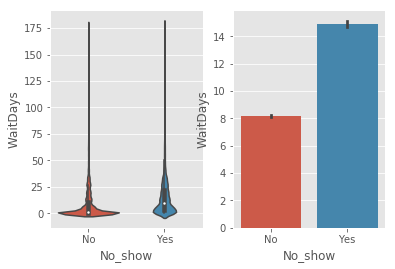

In [29]:
base_color = sb.color_palette()[0]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
sb.violinplot(x = df['No_show'], y = df['WaitDays'], data=df, ax=ax1)
sb.barplot(x=df.No_show, y = df.WaitDays, data=df, n_boot=1000, ax=ax2);

The violin plot indicates that as the days between the scheduled date and the appointment date increases, the number of no-shows increases, but the effect of the wait time increase diminishes somewhere between 35 and 50 days, so the relationship appears to be nonlinear. The people who showed on the left reinforce this with most people showing up closest to zero days of waiting. 

The bar chart on the right makes it much more clear that around 16 days most people do not show up. 

In [30]:
print(df.query('No_show=="Yes"')['WaitDays'].mode())
df.query('No_show=="Yes"')['WaitDays'].describe()

0    0
dtype: int64


count    22311.000000
mean        14.915961
std         16.531067
min          0.000000
25%          3.000000
50%         10.000000
75%         22.000000
max        178.000000
Name: WaitDays, dtype: float64

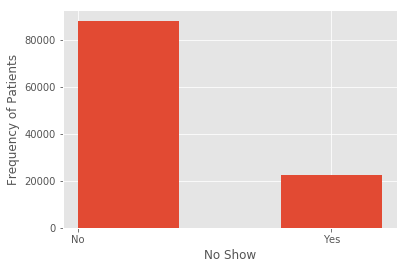

In [31]:
plt.hist(df['No_show'], bins=np.arange(0,1.4,.4))
plt.ylabel('Frequency of Patients')
plt.xlabel('No Show');

#Here we get a clear picture of how many no-shows at 1, and shows at 0.

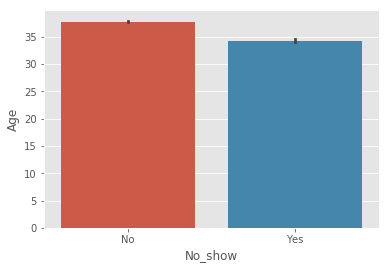

In [32]:
sb.barplot(x = df.No_show, y = df.Age, data = df, n_boot=1000);

Here we can see, for this sample, on average (as expected) the older patients are more likely to show up to the appointment, and younger more likely not to. 

### Research Question 1: Which explanatory variables have multicolinearity? That is, which variables highly correlate with each other? 

In [33]:
df.head()

,Gender,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,...,VILA RUBIM,Noshow_onehot,Gender_onehot,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4,Age_mmn,WaitDays_mmn
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,...,0,0,1,1,0,0,0,0,0.607843,0.0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,...,0,0,0,1,0,0,0,0,0.549020,0.0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,...,0,0,1,1,0,0,0,0,0.607843,0.0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,...,0,0,1,1,0,0,0,0,0.078431,0.0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,...,0,0,1,1,0,0,0,0,0.549020,0.0


In [34]:
df['intercept'] = 1
stats_model = sm.Logit(df.Noshow_onehot, df[['Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received',
                                             'Scholarship', 'Gender_onehot', 'Age_mmn', 'WaitDays_mmn']])
results = stats_model.fit()
results.summary()

y, X = dmatrices('Noshow_onehot ~ Hypertension + Diabetes + Alcoholism + Handicap + SMS_received + Scholarship + Gender_onehot + Age_mmn + WaitDays_mmn', df, return_type = 'dataframe')
vif = pd.DataFrame()
vif['VIF_factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Features'] = X.columns
vif

Optimization terminated successfully.
         Current function value: 0.519526
         Iterations 6


,VIF_factor,Features
0,5.799389,Intercept
1,1.532999,Hypertension
2,1.244678,Diabetes
3,1.031446,Alcoholism
4,1.010550,Handicap
5,1.179776,SMS_received
6,1.030186,Scholarship
7,1.046662,Gender_onehot
8,1.395340,Age_mmn
9,1.183209,WaitDays_mmn


### Research Question 2: Right now, if I used a statistical or machine learning models to predict all of the patients as shows I would get almost 80% accuracy. How can I balance the dataset without losing essential information or adding noise? 

In [35]:
majority = df.query('No_show == "No"').drop(['Gender', 'WaitDays', 'Age', 'Handicap', 'Neighborhood'], axis=1)

minority = df.query('No_show == "Yes"').drop(['Gender', 'WaitDays', 'Age', 'Handicap', 'Neighborhood'], axis=1)

maj_downsamp = resample(majority, 
                        replace=False,    # sampling without replacement will reduce this part of the dataset
                        n_samples=22316,     # this will reduce the dataset down to the size of the no-show
                        random_state=42) # ensures the results can be reproduced

In [36]:
downsamped_df = pd.concat([maj_downsamp, minority]) #this already has axis=0 zero as default which allows the dfs to be stacked
                                         #ontop of each other instead of joined side-by-side like I did in other situations
    
downsamped_df.Noshow_onehot.value_counts()

0    22316
1    22311
Name: Noshow_onehot, dtype: int64

### Research Question 2: What are the relative contributions of each feature to the no-show outcome? 

https://stackoverflow.com/questions/20703733/logit-regression-and-singular-matrix-error-in-python

In [37]:
features = downsamped_df.drop(['Noshow_onehot', 'No_show', 'SANTOS REIS', 'Handicap_0'], axis=1)
no_show = downsamped_df['Noshow_onehot']

df['intercept'] = 1

logit = sm.Logit(no_show, features)
results = logit.fit(method='bfgs', maxiter=100)
results.summary(), 

         Current function value: 0.656520
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(<class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:          Noshow_onehot   No. Observations:                44627
 Model:                          Logit   Df Residuals:                    44534
 Method:                           MLE   Df Model:                           92
 Date:                Tue, 09 Oct 2018   Pseudo R-squ.:                 0.05284
 Time:                        03:40:20   Log-Likelihood:                -29299.
 converged:                      False   LL-Null:                       -30933.
                                         LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
 -----------------------------------------------------------------------------------------------
 Scholarship                     0.1839      0.033      5.528      0.000       0.119       0.249
 Hypertension      

In [38]:
logit = sm.Logit(df.Noshow_onehot, df.Alcoholism)
results = logit.fit(method='bfgs')
results.summary()

Optimization terminated successfully.
         Current function value: 0.687350
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Noshow_onehot   No. Observations:               110516
Model:                          Logit   Df Residuals:                   110515
Method:                           MLE   Df Model:                            0
Date:                Tue, 09 Oct 2018   Pseudo R-squ.:                 -0.3665
Time:                        03:40:21   Log-Likelihood:                -75963.
converged:                       True   LL-Null:                       -55589.
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Alcoholism    -1.3761      0.043    -32.004      0.000      -1.460      -1.292
==============================================================================
"""

Notice how Alcoholism has dropped to below zero when running it alone through the logit model, while it is above zero when inputted with all the other features. This likely means it correlates with another variable or I preprocessed the data incorrectly. 

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

## References 

Alfred Wong's from Kaggle: https://www.kaggle.com/alfrednfwong/eda-no-shows-at-brazil-medical-appointments

Filtering outliers:
https://stackoverflow.com/questions/34782063/how-to-use-pandas-filter-with-iqr

Removing rows:
https://stackoverflow.com/questions/26921651/how-to-delete-the-last-row-of-data-of-a-pandas-dataframe